# ME5413 Homework 3: Planning

## Task 0: Load the Map

In [3]:
import numpy as np
import imageio
import matplotlib.pyplot as plt
%matplotlib inline

Size of the map: (1000, 1000)
Occupied Cells: 823039
Free Cells: 176961


/var/folders/lz/gbctgn7s6nl2h6srr2zm35m00000gn/T/ipykernel_60799/255792443.py:2: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  floor_plan = imageio.imread('../map/vivocity.png')
/var/folders/lz/gbctgn7s6nl2h6srr2zm35m00000gn/T/ipykernel_60799/255792443.py:3: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  grid_map_img = imageio.imread('../map/vivocity_freespace.png')


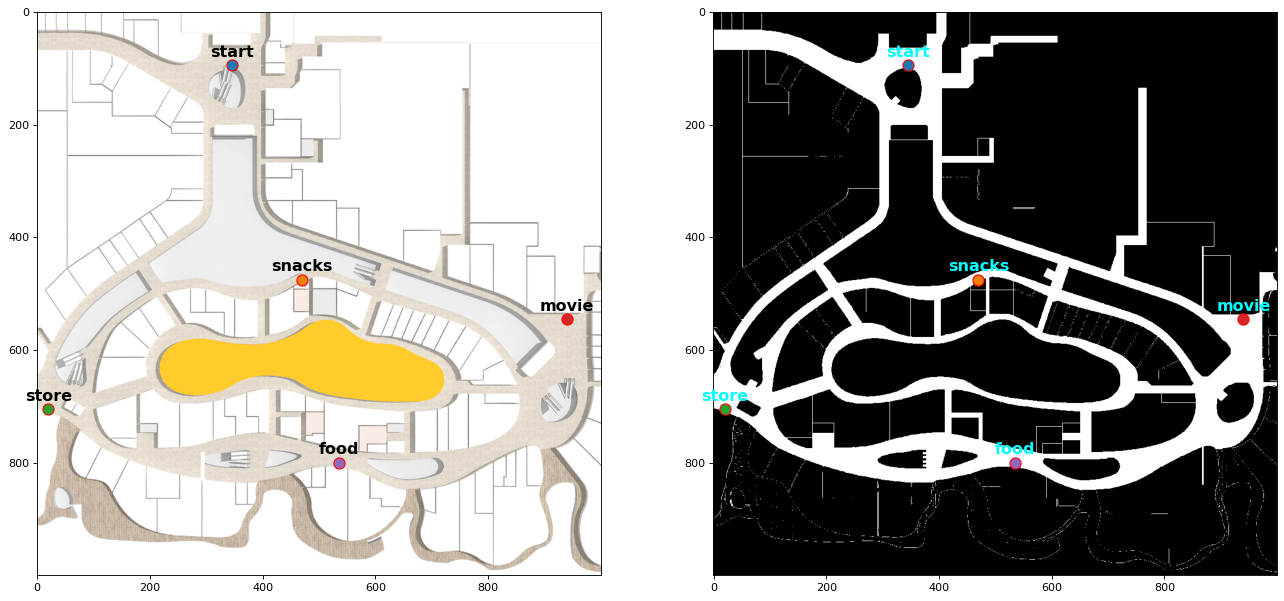

Cell start is free: True
Cell snacks is free: True
Cell store is free: True
Cell movie is free: True
Cell food is free: True


In [4]:
# Load the map
floor_plan = imageio.imread('../map/vivocity.png')
grid_map_img = imageio.imread('../map/vivocity_freespace.png')
grid_map = grid_map_img.transpose()
print("Size of the map:", grid_map.shape)
print("Occupied Cells:", np.count_nonzero(grid_map == 0))
print("Free Cells:", np.count_nonzero(grid_map == 255))

# Map resolution (Constant)
MAP_RES = 0.2 # each cell represents a 0.2m x 0.2m square in reality

# Locations on the map
locations = {'start':  [345, 95],    # Start from the level 2 Escalator
             'snacks': [470, 475],   # Garrett Popcorn
             'store':  [20, 705],    # DJI Store
             'movie':  [940, 545],   # Golden Village
             'food':   [535, 800],   # PUTIEN
            }

# A helper function to mark the locations on the map
def plot_locations(locations: dict, color: 'str'='black'):
    for key, value in locations.items():
        plt.plot(locations[key][0], locations[key][1], marker="o", markersize=10, markeredgecolor="red")
        plt.text(locations[key][0], locations[key][1]-15, s=key, fontsize='x-large', fontweight='bold', c=color, ha='center')
    return

# Plot the locaitons on the map 
plt.figure(figsize=(20, 10), dpi=80)
plt.subplot(1,2,1)
plt.imshow(floor_plan)
plot_locations(locations)
plt.subplot(1,2,2)
plt.imshow(grid_map_img, cmap='gray')
plot_locations(locations, color='cyan')
plt.show()

# Check if the designated locations are free
for key, value in locations.items():
    print(f"Cell {key} is free: {grid_map[value[0], value[1]] == 255}")

## Task 1

### Node Class: to record node information

In [5]:
class Node:
    """
    A class to represent a node in the A* search algorithm.

    param:
        x: x coordinate of the node
        y: y coordinate of the node
        g_cost(cost-so-far): cost from start node to current node
        h_cost(cost-to-go): heuristic cost from current node to goal node
        f_cost: g_cost + h_cost
        parent_node: parent node of the current node
    """
    def __init__(self, x, y,g_cost=float('inf'),h_cost=0):
        self.x = x
        self.y = y
        self.g_cost = g_cost
        self.h_cost = h_cost
        self.f_cost = g_cost + h_cost
        self.parent_node=None  # Parent node, used for backtracking the path

    def __lt__(self, other):
        """
        To enable heapq to sort based on f_cost
        implement the __lt__ method (less-than operator) in the Node class 
        so that heapq can compare node objects.
        """
        return self.f_cost < other.f_cost
        

### AStarPlanner Class: to realize A* algorithm

In [6]:
import heapq
from itertools import permutations

class AStarPlanner:
    """
    A class to represent the A* search algorithm.
    """
    def __init__(self, map_data, heuristic_type='euclidean'):
        self.map = map_data
        # self.map_resolution = MAP_RES
        self.height, self.width = map_data.shape
        self.directions = [(0,1),(1,0),(0,-1),(-1,0),
                           (1,1),(1,-1),(-1,1),(-1,-1)]
        self.heuristic_type = heuristic_type
        
    
    def heuristic(self, start, goal):
        """
        Calculate the heuristic value 
        Euclidean distance or Manhattan distance
        """
        if self.heuristic_type == 'euclidean':
            return np.sqrt((start[0] - goal[0])**2 + (start[1] - goal[1])**2)
        elif self.heuristic_type == 'manhattan':
            return abs(start[0] - goal[0]) + abs(start[1] - goal[1])
        else:
            raise ValueError(f"Invalid heuristic type: {self.heuristic_type}")
    

    def is_valid(self,x,y):
        """
        Check if the coordinate is within the map range
        Check if the coordinate is traversable
        """
        if 0 <= x < self.width and 0 <= y < self.height:
            return self.map[x][y] == 255
        return False
    
    def find_path(self, start, goal):
        """
        Find the shortest path between two points using the A* search algorithm.
        """
        start_node = Node(start[0], start[1],0,self.heuristic(start, goal))
        open_list = []
        closed_set = set()
        # Initialize the open list and the closed set
        heapq.heappush(open_list, start_node)
        nodes={(start[0],start[1]):start_node}

        while open_list:
            current_node=heapq.heappop(open_list)

            if current_node.x==goal[0] and current_node.y==goal[1]:
                # Found the path, backtrack and return
                path=[]
                while current_node:
                    path.append((current_node.x,current_node.y))
                    # current_node=nodes.get(current_node.parent_node)
                    current_node=current_node.parent_node
                # path.reverse()  
                # print(f"Path found: {path}")
                return path[::-1]
            
            closed_set.add((current_node.x,current_node.y))

            for dx,dy in self.directions:
                # next_x=current_node.x+dx
                # next_y=current_node.y+dy
                next_pos=(current_node.x+dx,current_node.y+dy)

                if not self.is_valid(next_pos[0],next_pos[1]) or next_pos in closed_set:
                    continue
                
                # Calculate the new g_cost (if the movement is diagonal, the distance is √2)
                movement_cost = np.sqrt(2) if dx*dy != 0 else 1
                new_g_cost = current_node.g_cost + movement_cost

                if next_pos not in nodes or new_g_cost < nodes[next_pos].g_cost:
                    next_node=Node(next_pos[0],next_pos[1],new_g_cost,self.heuristic(next_pos, goal))
                    next_node.parent_node=current_node
                    nodes[next_pos]=next_node
                    heapq.heappush(open_list,next_node)
                    # print(f"Added/Updated node at {next_pos}, f_cost: {next_node.f_cost}")
        
        return None
    
    def calculate_path_distance(self, path):
        """
        Calculate the distance of the path
        """
        distance = 0
        for i in range(len(path)-1):
            distance += self.heuristic(path[i], path[i+1])
        return distance
    

### Calculate Distances

In [7]:
def calculate_distance_matrix(astar_planner, locations):
    """
    Calculate the distance matrix between all locations using the A * algorithm
    
    Parameters:
        astar_planner: initialized A* planner instance
        locations: dictionary containing all location coordinates
    
    Returns:
        distance_matrix: distance matrix, where distance_matrix[i][j] represents the distance from location i to location j
        location_indices: dictionary mapping location names to indices
    """
    location_names = list(locations.keys())
    n = len(location_names)
    
    # Create a mapping of location names to indices
    location_indices = {name: idx for idx, name in enumerate(location_names)}
    
    # Initialize the distance matrix
    distance_matrix = np.zeros((n, n))
    paths = {}  # Store path information, possibly for later visualization
    
    # Calculate the distance between each pair of locations
    for i in range(n):
        for j in range(n):
            if i != j:  # Do not calculate the distance from a location to itself
                start = locations[location_names[i]]
                goal = locations[location_names[j]]
                
                # Calculate the distance and path using the A* algorithm
                path= astar_planner.find_path(start, goal)
                distance = astar_planner.calculate_path_distance(path)
                # Store the distance and path
                distance_matrix[i, j] = distance
                paths[(location_names[i], location_names[j])] = path
    
    return distance_matrix, location_indices, paths

# Create an A* planner instance
astar_planner = AStarPlanner(grid_map, heuristic_type='euclidean')

# Calculate the distance matrix
distance_matrix, location_indices, paths = calculate_distance_matrix(astar_planner, locations)

# Display the distance matrix
location_names = list(locations.keys())
print("Distance Matrix (Unit: meters):")
print("     ", end="")
for name in location_names:
    print(f"{name:>8}", end="")
print()

for i, name1 in enumerate(location_names):
    print(f"{name1:>5}", end="")
    for j, name2 in enumerate(location_names):
        if i == j:
            print(f"{'-':>8}", end="")
        else:
            print(f"{distance_matrix[i, j]:>8.2f}", end="")
    print()

Distance Matrix (Unit: meters):
        start  snacks   store   movie    food
start       -  705.26  772.15  892.11 1094.44
snacks  705.26       -  571.63  532.72  648.50
store  772.15  571.63       - 1042.60  554.35
movie  892.11  532.72 1042.60       -  556.90
 food 1094.44  648.50  554.35  556.90       -


## Task 2

### Brute Force Enumeration

In [8]:
def brute_force_tsp(distance_matrix):
    """
    Use brute force enumeration to solve the TSP problem
    
    Parameters:
        distance_matrix: distance matrix
        
    Returns:
        best_route: best route index list
        min_distance: shortest total distance
    """
    n = len(distance_matrix)
    start_idx = 0  # 起点/终点索引（对应'start'位置）
    
    # 生成除起点外所有地点的排列
    other_locations = list(range(1, n))
    min_distance = float('inf')
    best_route = None
    
    # 列举所有可能路径
    for perm in permutations(other_locations):
        # 构建完整路径：start -> 所有地点 -> start
        route = [start_idx] + list(perm) + [start_idx]
        
        # 计算总距离
        total_distance = 0
        for i in range(len(route) - 1):
            total_distance += distance_matrix[route[i]][route[i+1]]
        
        # 更新最短距离和最佳路径
        if total_distance < min_distance:
            min_distance = total_distance
            best_route = route
    
    return best_route, min_distance


### Nearest Neighbor Greedy Algorithm

In [9]:
def nearest_neighbor_tsp(distance_matrix):
    """
    Use the nearest neighbor greedy algorithm to solve the TSP problem
    
    Parameters:
        distance_matrix: distance matrix
        
    Returns:
        route: index list of the path
        total_distance: total distance
    """
    n = len(distance_matrix)
    start_idx = 0  # start/goal index (corresponding to 'start' location)
    
    # Initialize
    unvisited = set(range(1, n))  # all locations except the start
    route = [start_idx]
    current = start_idx
    total_distance = 0
    
    # Greedy selection of the nearest unvisited location
    while unvisited:
        next_loc = min(unvisited, key=lambda x: distance_matrix[current][x])
        route.append(next_loc)
        total_distance += distance_matrix[current][next_loc]
        unvisited.remove(next_loc)
        current = next_loc
    
    # Return to the start
    route.append(start_idx)
    total_distance += distance_matrix[current][start_idx]
    
    return route, total_distance


In [10]:
# Apply two algorithms to solve the TSP problem
brute_force_route, brute_force_distance = brute_force_tsp(distance_matrix)
nearest_neighbor_route, nearest_neighbor_distance = nearest_neighbor_tsp(distance_matrix)

# Convert the index path to location names
location_names = list(locations.keys())
brute_force_path = [location_names[i] for i in brute_force_route]
nearest_neighbor_path = [location_names[i] for i in nearest_neighbor_route]

# Output the results comparison
print("\nBrute Force Enumeration:")
print(f"Shortest Path: {' -> '.join(brute_force_path)}")
print(f"Total Distance: {brute_force_distance:.2f} meters")

print("\nNearest Neighbor Greedy Algorithm:")
print(f"Path: {' -> '.join(nearest_neighbor_path)}")
print(f"Total Distance: {nearest_neighbor_distance:.2f} meters")


Brute Force Enumeration:
Shortest Path: start -> snacks -> movie -> food -> store -> start
Total Distance: 3121.38 meters

Nearest Neighbor Greedy Algorithm:
Path: start -> snacks -> movie -> food -> store -> start
Total Distance: 3121.38 meters
